In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from tqdm import tqdm
import concurrent.futures
from sklearn.decomposition import PCA

In [2]:
# Simulated data: small undirected adjacency matrix
np.random.seed(0)
n_nodes = 10
# Generate a random symmetric adjacency matrix (no self-loops)
A = np.random.rand(n_nodes, n_nodes) < 0.2
A = np.triu(A, 1)
A = A + A.T
A = A.astype(np.float32)

# Read data

In [3]:
# Try this on the Stanford Encyclopedia of Philosophy graph (1998)
# https://github.com/adamdedwards/sep-graph/tree/master/data

# Read the network
def load_labeled_network_and_get_largest_wcc(edge_file, node_file):
    # Step 1: Read node labels
    with open(node_file, 'r') as f:
        node_labels = set(line.strip().split(',')[0] for line in f if line.strip())

    # Step 2: Read edge list with labels directly
    G = nx.read_edgelist(edge_file, create_using=nx.DiGraph(), nodetype=str, delimiter=',')
    G = G.reverse(copy=True)

    # Step 3: Filter to only valid nodes from node list
    G = G.subgraph([n for n in G.nodes if n in node_labels]).copy()

    # Step 4: Get largest weakly connected component
    components = list(nx.weakly_connected_components(G))
    largest_wcc = max(components, key=len)
    G_wcc = G.subgraph(largest_wcc).copy()

    return G_wcc

In [4]:
G_wcc = load_labeled_network_and_get_largest_wcc('data/1998_fall_edge_list.csv', 'data/1998_fall_node_list.csv')
node_list = list(G_wcc.nodes)
A_wcc = nx.to_numpy_array(G_wcc, nodelist=node_list)

In [5]:
A = A_wcc
n_nodes = A.shape[0]

# Functions for inference

In [ ]:
################################ V1
# def compute_s(X):
#     return np.linalg.norm(X, axis=1)

# def compute_lij(X):
#     s = compute_s(X)
#     dot = X @ X.T
#     denom = np.outer(s, s)
#     l = dot / (denom + 1e-9)
#     return np.clip(l, -1, 1)  # prevent instability

# def log_likelihood(X, A, beta):
#     s = compute_s(X)
#     l = compute_lij(X)
#     L = 0.0
#     for i in range(n_nodes):
#         for j in range(n_nodes):
#             if i == j:
#                 continue
#             sij = s[i] - s[j]
#             lij = l[i, j]
#             L += A[i, j] * np.log(1 + lij + 1e-9)
#             L -= np.log(2 * (1 + np.exp(-beta * (1 + lij) * sij)) + 1e-9)
#             L += (1 - A[i, j]) * np.log(1 - lij + 2 * np.exp(-beta * (1 + lij) * sij) + 1e-9)
#     return L

# # Gradient approximation (numerical)
# def numerical_gradient(X, A, beta, epsilon=1e-5):
#     grad = np.zeros_like(X)
#     base = log_likelihood(X, A, beta)
#     for i in range(X.shape[0]):
#         for j in range(X.shape[1]):
#             X_perturb = X.copy()
#             X_perturb[i, j] += epsilon
#             new_val = log_likelihood(X_perturb, A, beta)
#             grad[i, j] = (new_val - base) / epsilon
#     return grad

# # Gradient ascent with annealed learning rate
# def optimize_embeddings(X, A, beta, lr, max_iter, anneal):
#     history = []
#     for it in tqdm(range(max_iter)):
#         grad = numerical_gradient(X, A, beta)
#         alpha = lr / (1 + 0.05 * it) if anneal else lr
#         X += alpha * grad
#         ll = log_likelihood(X, A, beta)
#         # print(ll)
#         history.append(ll)
#     return (X, history)

# def optimize_embeddings_parallel(args):
#     return optimize_embeddings(*args)

In [ ]:
######################################## V2
# def compute_s(X):
#     return np.linalg.norm(X, axis=1)

# def compute_lij(X):
#     s = compute_s(X)
#     dot = X @ X.T
#     denom = np.outer(s, s)
#     l = dot / (denom + 1e-9)
#     return np.clip(l, -1, 1)  # prevent instability

# def log_likelihood(X, A, beta, k):
#     s = compute_s(X)
#     l = compute_lij(X)
    
#     L = 0.0
#     for i in range(n_nodes):
#         for j in range(n_nodes):
#             if i == j:
#                 continue
#             sij = s[i] - s[j]
#             lij = l[i, j]
#             L += A[i, j] * np.log(((1 + lij) / 2) ** k / ((1 + np.exp(-beta * sij * (1 + lij) ** k))) + 1e-9)
#             # L -= np.log(2 * (1 + np.exp(-beta * (1 + lij) * sij)) + 1e-9)
#             L += (1 - A[i, j]) * np.log(1 - (((1 + lij) / 2) ** k / ((1 + np.exp(-beta * sij * (1 + lij) ** k)))) + 1e-9)
#     return L

# # Gradient approximation (numerical)
# def numerical_gradient(X, A, beta, k, epsilon=1e-5):
#     grad = np.zeros_like(X)
#     base = log_likelihood(X, A, beta, k)
#     for i in range(X.shape[0]):
#         for j in range(X.shape[1]):
#             X_perturb = X.copy()
#             X_perturb[i, j] += epsilon
#             new_val = log_likelihood(X_perturb, A, beta, k)
#             grad[i, j] = (new_val - base) / epsilon
#     return grad

# # Gradient ascent with annealed learning rate
# def optimize_embeddings(X, A, beta, k, lr, max_iter, anneal):
#     history = []
#     for it in tqdm(range(max_iter)):
#         grad = numerical_gradient(X, A, beta, k)
#         alpha = lr / (1 + 0.05 * it) if anneal else lr
#         X += alpha * grad
#         ll = log_likelihood(X, A, beta, k)
#         # print(ll)
#         history.append(ll)
#     return (X, history)

# def optimize_embeddings_parallel(args):
#     return optimize_embeddings(*args)

In [73]:
######################################## V3
def compute_s(X):
    return np.linalg.norm(X, axis=1)

def compute_lij(X):
    s = compute_s(X)
    dot = X @ X.T
    denom = np.outer(s, s)
    l = dot / (denom + 1e-9)
    return np.clip(l, -1, 1)  # prevent instability

def log_likelihood(X, A, alpha, beta):
    s = compute_s(X)
    l = compute_lij(X)
    
    L = 0.0
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i == j:
                continue
            sij = s[i] - s[j]
            lij = l[i, j]
            L += alpha * A[i, j] * lij
            L -= np.log(1 + np.exp(-beta * (1 + lij) * sij) + 1e-9)
            # print((1 / alpha * (1 - np.exp(-2 * alpha))) * (1 + np.exp(-beta * sij * (1 + lij))) - np.exp(alpha * (lij - 1)) + 1e-9)
            L += (1 - A[i, j]) * np.log(1 + np.exp(-beta * sij * (1 + lij)) - np.exp(alpha * (lij - 1))  + 1e-9)#* alpha / (1 - np.exp(-2 * alpha))) + 1e-9)
    return L

# Gradient approximation (numerical)
def numerical_gradient(X, A, alpha, beta, epsilon=1e-5):
    grad = np.zeros_like(X)
    base = log_likelihood(X, A, alpha, beta)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X_perturb = X.copy()
            X_perturb[i, j] += epsilon
            new_val = log_likelihood(X_perturb, A, alpha, beta)
            grad[i, j] = (new_val - base) / epsilon
    return grad

# Gradient ascent with annealed learning rate
def optimize_embeddings(X, A, alpha, beta, lr, max_iter, anneal):
    history = []
    for it in tqdm(range(max_iter)):
        grad = numerical_gradient(X, A, alpha, beta)
        adjusted_lr = lr / (1 + 0.05 * it) if anneal else lr
        X += adjusted_lr * grad
        ll = log_likelihood(X, A, alpha, beta)
        # print(ll)
        history.append(ll)
    return (X, history)

def optimize_embeddings_parallel(args):
    return optimize_embeddings(*args)

# Infer model parameters

In [74]:
d = 4  # embedding dimension
beta = 1
lr = 0.2
max_iter=300
anneal=True

# # Initialize random embeddings
# X = np.random.randn(n_nodes, d)

# Run the optimizer
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(optimize_embeddings_parallel, [(np.random.randn(n_nodes, d), A, alpha, beta, lr, max_iter, anneal) for alpha in np.arange(1, 9, 1)]))

100%|██████████| 300/300 [13:14<00:00,  2.65s/it]


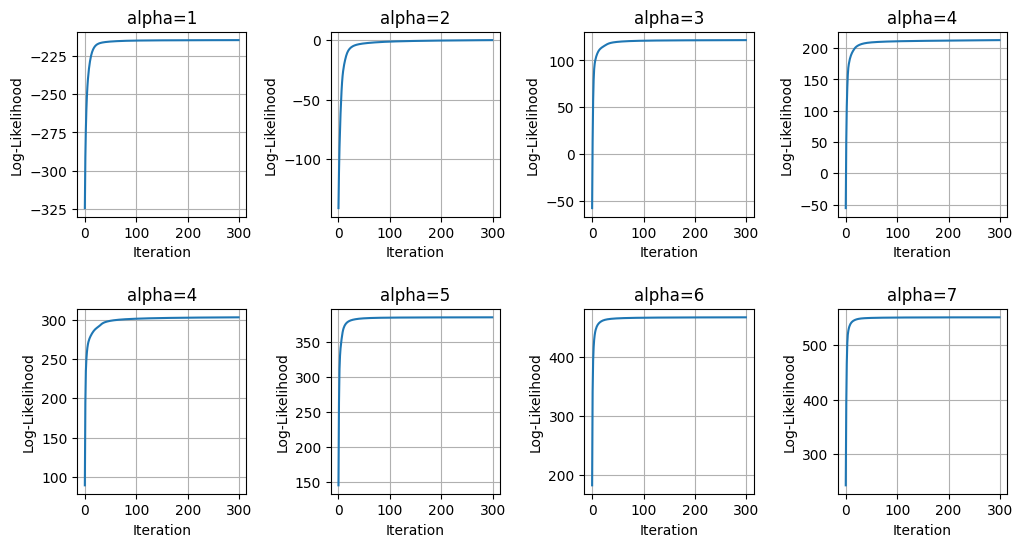

In [86]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(2):
    for j in range(4):
        axes[i, j].plot(results[i * 4 + j][1])
        axes[i, j].set_xlabel('Iteration')
        axes[i, j].set_ylabel('Log-Likelihood')
        axes[i, j].set_title(f'alpha={1 + i * 3 + j}')
        axes[i, j].grid(True)

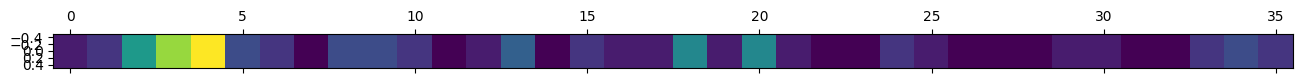

In [76]:
plt.matshow(A_wcc.sum(axis=1).reshape(1, A.shape[0]))

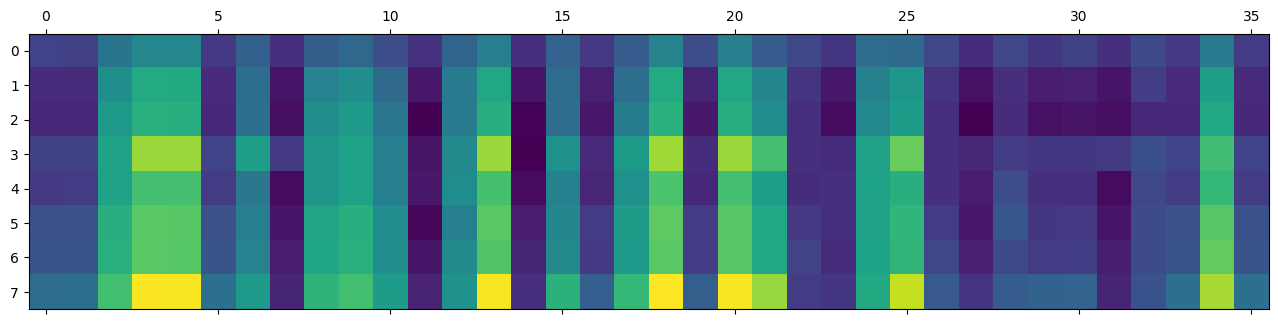

In [77]:
plt.matshow(np.vstack([np.linalg.norm(results[i][0], axis=1) for i in range(len(results))]))

# Plot dimensionality reduced model embeddings and show edges

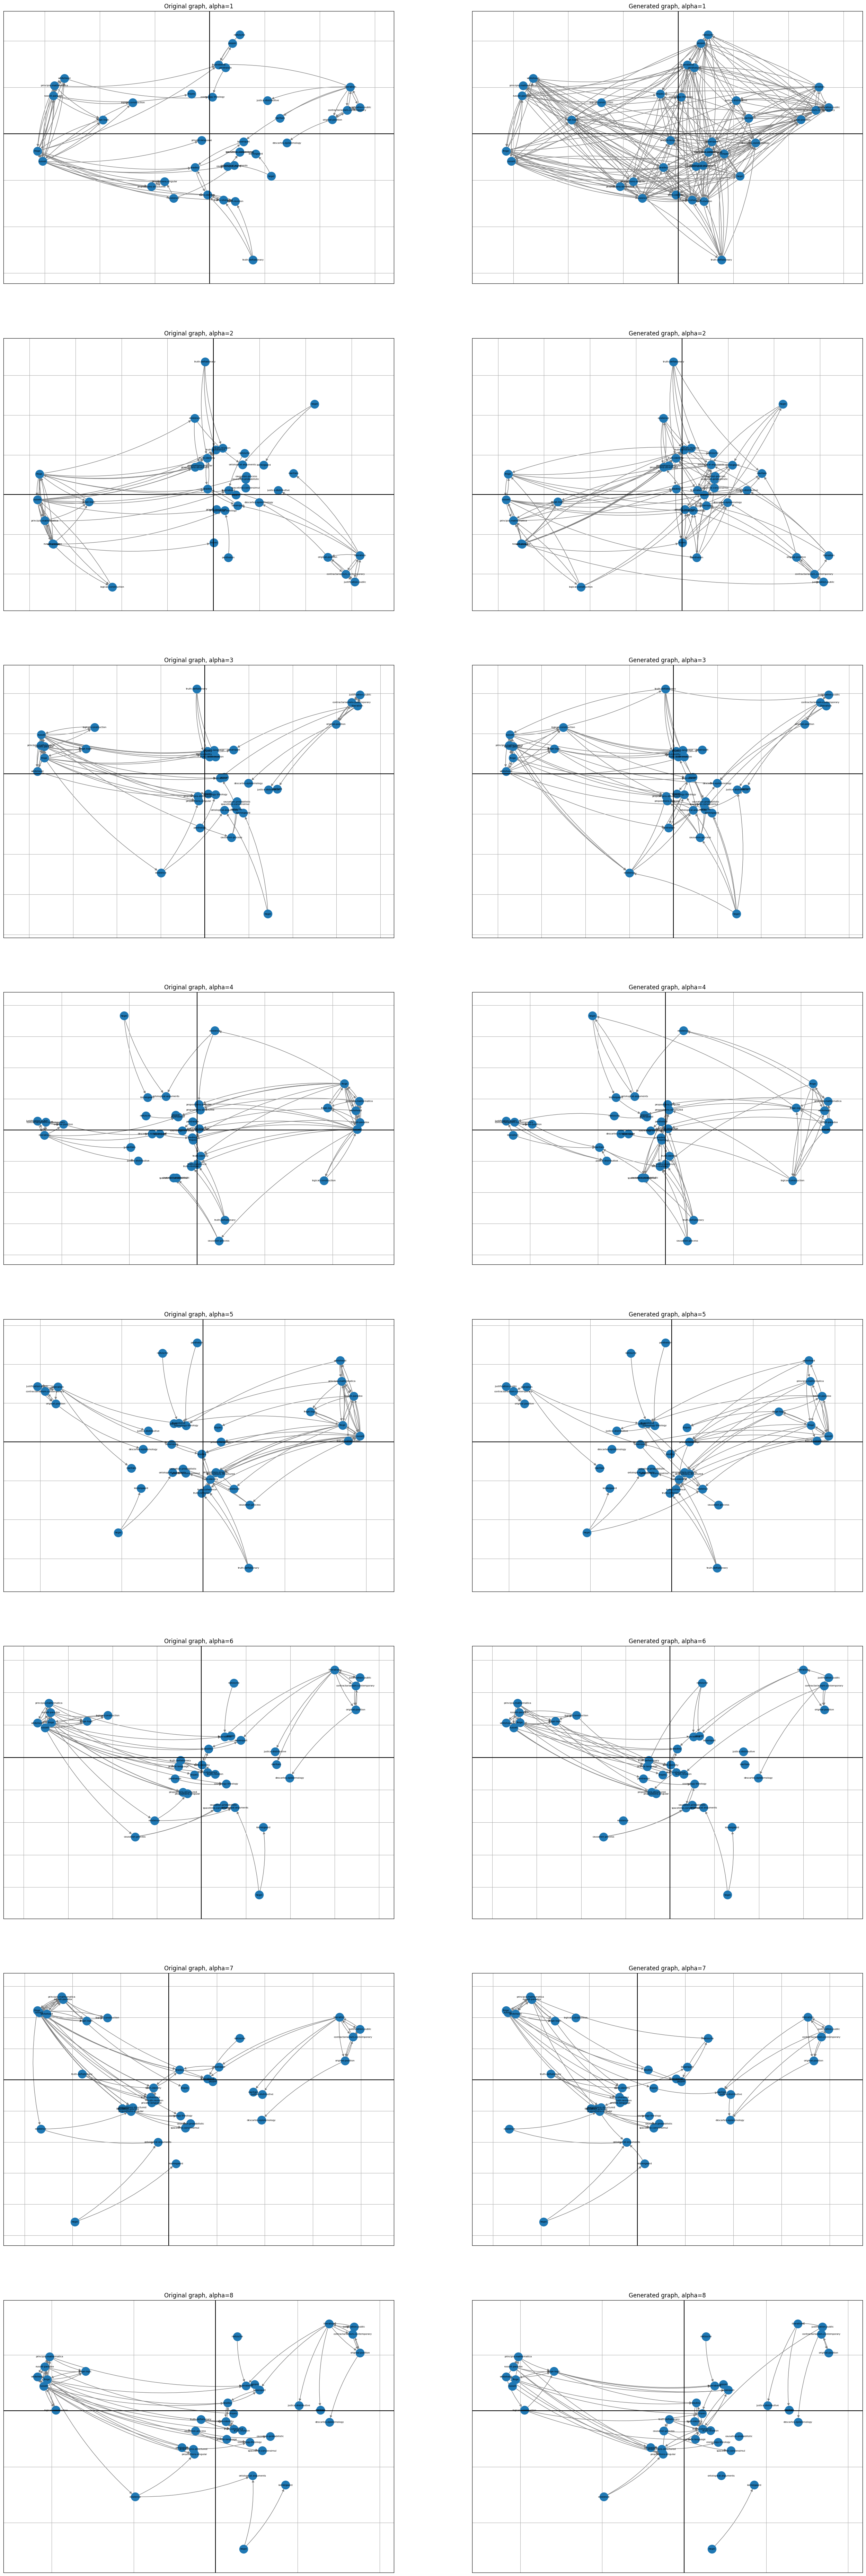

In [83]:
fig, axes = plt.subplots(8, 2, figsize=(32, 96))

node_size=300
font_size=5
arrowsize=10

beta = 1

for alpha in range(1, 9):
    axs = axes[alpha - 1]
    # Use a layout: spring, kamada_kawai, etc.
    # pos = nx.spring_layout(G_wcc, k=1)
    pos = {node_list[i]: pos for i, pos in enumerate(PCA(n_components=2).fit_transform(results[alpha - 1][0]))}

    # Draw nodes and edges
    nx.draw_networkx_nodes(G_wcc, pos, node_size=node_size, ax=axs[0])
    nx.draw_networkx_edges(G_wcc, pos, arrows=True, arrowsize=arrowsize, connectionstyle='arc3,rad=0.1', edge_color='0.5', ax=axs[0])
    nx.draw_networkx_labels(G_wcc, pos, font_size=font_size, ax=axs[0])

    axs[0].axhline(y=0,
                color='0.0')
    axs[0].axvline(x=0,
                color='0.0')
    axs[0].grid(True)
    axs[0].set_title(f"Original graph, alpha={alpha}")

    # Generate adjacency matrix
    A_gen = np.zeros(A.shape)

    s_gen = compute_s(results[alpha - 1][0])
    l_gen = compute_lij(results[alpha - 1][0])

    for i in range(len(A_gen)):
        for j in range(i + 1, len(A_gen)):
            rand_draw = np.random.rand()
            if rand_draw < np.exp(alpha * (l_gen[i, j] - 1)):
                # A_gen[i, j] = 1
                if np.random.rand() < (1 / (1 + np.exp(-beta * (1 + l_gen[i, j]) * (s_gen[i] - s_gen[j])))):
                    A_gen[i, j] = 1
                if np.random.rand() < (1 / (1 + np.exp(-beta * (1 + l_gen[i, j]) * (s_gen[j] - s_gen[i])))):
                    A_gen[j, i] = 1
            # else:
            #     A_gen[i, j] = 0
            #     A_gen[j, i] = 0

    # Create netowrkx network
    # Step 1: Create directed graph from matrix
    G_gen = nx.from_numpy_array(A_gen, create_using=nx.DiGraph)

    # Step 2: Assign custom labels
    mapping = {i: node_list[i] for i in range(A_gen.shape[0])}
    G_gen = nx.relabel_nodes(G_gen, mapping)

    # Use a layout: spring, kamada_kawai, etc.
    # pos = nx.spring_layout(G_gen, k=1)
    pos = {node_list[i]: pos for i, pos in enumerate(PCA(n_components=2).fit_transform(results[alpha - 1][0]))}

    # Draw nodes and edges
    nx.draw_networkx_nodes(G_gen, pos, node_size=node_size, ax=axs[1])
    nx.draw_networkx_edges(G_gen, pos, arrows=True, arrowsize=arrowsize, connectionstyle='arc3,rad=0.1', edge_color='0.5', ax=axs[1])
    nx.draw_networkx_labels(G_gen, pos, font_size=font_size, ax=axs[1])

    axs[1].axhline(y=0,
                color='0.0')
    axs[1].axvline(x=0,
                color='0.0')
    axs[1].grid(True)
    axs[1].set_title(f"Generated graph, alpha={alpha}")

fig.savefig('network-generation-alpha.pdf', bbox_inches='tight')

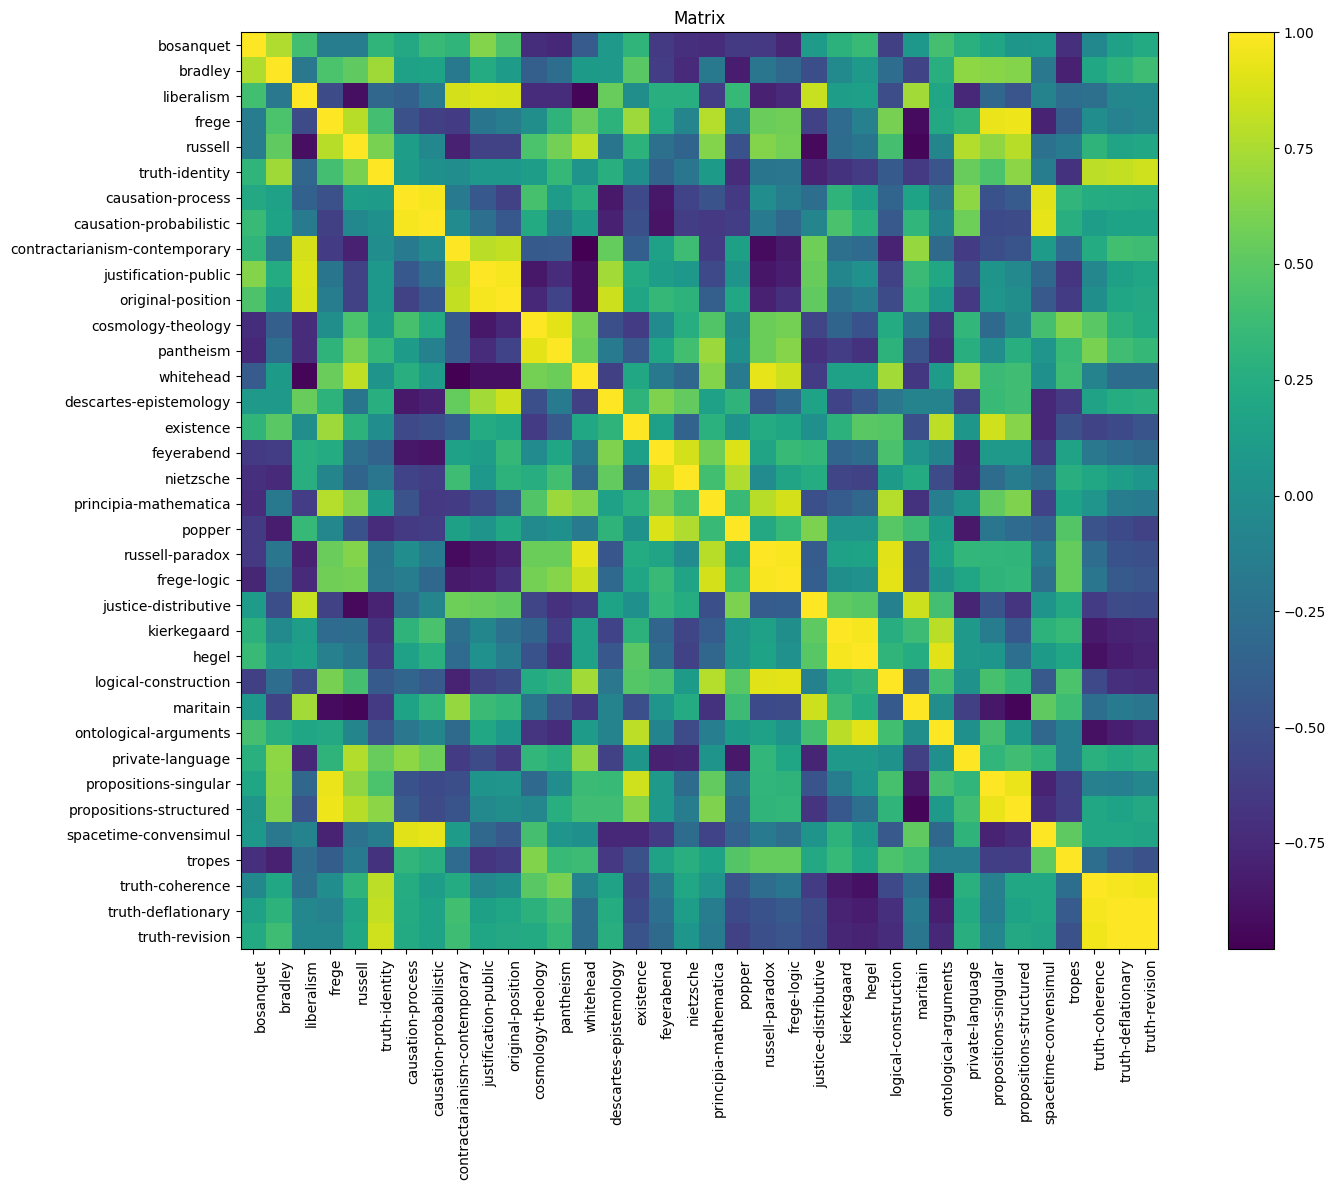

In [287]:
def plot_matrix_with_labels(matrix, labels, title="Matrix", cmap="viridis"):
    """
    matrix: 2D NumPy array
    labels: list of labels for both rows and columns
    """
    fig, ax = plt.subplots(figsize=(16, 12))
    cax = ax.imshow(matrix, interpolation='nearest', cmap=cmap)

    # Add labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate x labels and align
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    ax.set_title(title)
    fig.colorbar(cax)
    plt.tight_layout()
    plt.show()

plot_matrix_with_labels(l_gen, node_list)

Text(0.5, 1.0, '$d_{ij} = \\left(\\frac{1 + l_{ij}}{2}\\right); l_{ij}$ is the cosine distance')

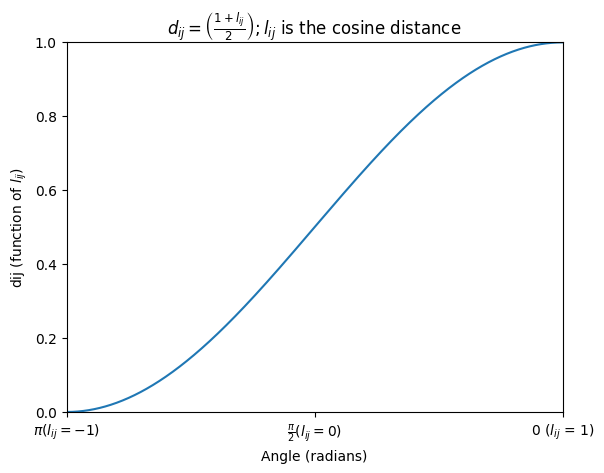

In [ ]:
fig, axes = plt.subplots()
axes.plot(np.arange(0, np.pi, np.pi / 1000)[::-1], (1 + np.cos(np.arange(0, np.pi, np.pi / 1000)[::-1])) / 2)#np.exp(20 * (np.cos(np.arange(0, np.pi, np.pi / 1000)) - 1))[::-1])
axes.set_xlim([np.pi, 0])
axes.set_ylim([0, 1])
axes.set_xlabel('Angle (radians)')
axes.set_ylabel('dij (function of $l_{ij}$)')
axes.set_xticks(np.arange(np.pi, -0.1, -np.pi / 2), ['$\pi (l_{ij} = -1)$', '$\\frac{\pi}{2} (l_{ij} = 0)$', '0 ($l_{ij}$ = 1)'])
axes.set_title('$d_{ij} = \\left(\\frac{1 + l_{ij}}{2}\\right); l_{ij}$ is the cosine distance')
axes.spines.

Text(0.5, 1.0, '$d_{ij} = \\left(\\frac{1 + l_{ij}}{2}\\right); l_{ij}$ is the cosine distance')

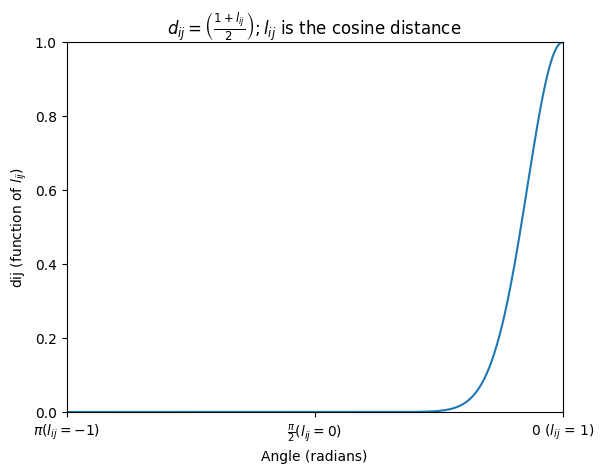

In [106]:
fig, axes = plt.subplots()
axes.plot(np.arange(0, np.pi, np.pi / 1000)[::-1], np.exp(20 * (np.cos(np.arange(0, np.pi, np.pi / 1000)) - 1))[::-1])#np.exp(20 * (np.cos(np.arange(0, np.pi, np.pi / 1000)) - 1))[::-1])
axes.set_xlim([np.pi, 0])
axes.set_ylim([0, 1])
axes.set_xlabel('Angle (radians)')
axes.set_ylabel('dij (function of $l_{ij}$)')
axes.set_xticks(np.arange(np.pi, -0.1, -np.pi / 2), ['$\pi (l_{ij} = -1)$', '$\\frac{\pi}{2} (l_{ij} = 0)$', '0 ($l_{ij}$ = 1)'])
axes.set_title('$d_{ij} = \\left(\\frac{1 + l_{ij}}{2}\\right); l_{ij}$ is the cosine distance')
# axes.spines.